In [1]:
import matplotlib.pyplot as plt
import numpy
import os

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# read dir and search for WHITE, DARK and OBJECT (RAW and HDR)
def readDir(dir_path):
    myDir = os.listdir(dir_path)
    print(myDir)
    dark_hdr =[]
    dark_raw=[]
    white_hdr=[]
    white_raw=[]
    for file in myDir:
        if 'dark' in file.lower() and 'hdr' in file.lower():
            #dark_hdr = dir_path + '/' + file
            dark_hdr = os.path.join(dir_path, file)
        if 'dark' in file.lower() and 'raw' in file.lower():
            #dark_raw = dir_path + '/' + file
            dark_raw = os.path.join(dir_path, file)
        if 'white' in file.lower() and 'hdr' in file.lower():
            #white_hdr = dir_path + '/' + file
            white_hdr = os.path.join(dir_path, file)
        if 'white' in file.lower() and 'raw' in file.lower():
            #white_raw = dir_path + '/' + file
            white_raw = os.path.join(dir_path, file)
        if (not 'white' in file.lower()) and (not 'dark' in file.lower()) and 'hdr' in file.lower():
            #object_hdr = dir_path + '/' + file
            object_hdr = os.path.join(dir_path, file)
        if (not 'white' in file.lower()) and (not 'dark' in file.lower()) and 'raw' in file.lower():
            #object_raw = dir_path + '/' + file
            object_raw = os.path.join(dir_path, file)
    return object_raw, object_hdr, white_raw, white_hdr, dark_raw, dark_hdr  

In [3]:
##### Read HDR content
def read_hdr(hdr_path):
    f=open(hdr_path, "r")
    filelines = f.readlines()
    #print(filelines)
    f.close()
    bands = ''
    for fileline in filelines:
        #print(fileline)
        if 'samples' in fileline.lower():
            samples = int(fileline.replace('samples = ',''))
            #print(samples)
        if bands =='' and 'bands' in fileline.lower():
            bands = int(fileline.replace('bands = ',''))
        if 'lines' in fileline.lower():
            lines = int(fileline.replace('lines = ',''))
    # read waves   
    print('Original Size: ', lines, bands, samples)
    n = 0
    for fileline in filelines:
        if 'th = {' in fileline.lower():
          #print(n)
          n1 = n+1
        n = n + 1
    n2 = n1 + bands
    #print(n1)
    #print(n2)
    waves = numpy.zeros(n2-n1,)
    n = 0
    for i in range(n1, n2):
        #print(filelines[i])
        waves[n] = float(filelines[i].replace(',',''))
        #print(waves[n])
        n = n + 1
    
    return samples, bands, lines, waves     

In [4]:
def read_raw(hdr_path, raw_path, line_start, line_read):
  #Read object hdr File
  [samples, bands, lines, waves] = read_hdr(hdr_path)
  fopen = open(raw_path, "rb")

  if (line_start == -1 or line_read == -1):
    # Read white or dark reference
    raw_white = numpy.fromfile(fopen, dtype=numpy.uint16)
    cube = numpy.reshape(raw_white, (lines, bands, samples))
  else:
    # Read object raw
    fopen.seek(samples*bands*line_start*2) # we skip 'line_start' number of lines
    raw_part = numpy.fromfile(fopen, dtype=numpy.uint16, count=samples*bands*line_read) # we read only 'line_read' number of lines
    cube = numpy.reshape(raw_part, (line_read, bands, samples))
    print('Resized to: ', cube.shape)
    print(waves)

  return cube, waves


In [5]:
def preview_RGB(spectral_cube, ch_1, ch_2, ch_3):
  lines, bands, samples = spectral_cube.shape
  RGB = numpy.empty((lines, samples, 3)) # Create a 'bmp' array with spatial size of ENVI 512,512 with 3 layers
  RGB[:,:,0] = spectral_cube[:,ch_1,:]/numpy.amax(spectral_cube[:,ch_1,:]) # np.amax gets max value. Thus we get RGB in range [0,1]
  RGB[:,:,1] = spectral_cube[:,ch_2,:]/numpy.amax(spectral_cube[:,ch_2,:])
  RGB[:,:,2] = spectral_cube[:,ch_3,:]/numpy.amax(spectral_cube[:,ch_3,:])
  plt.rcParams['figure.dpi'] = 200
  plt.imshow(RGB)
  plt.show()
  return RGB

In [6]:
def read_n_preview(path, line_start, line_read, ch_1, ch_2, ch_3):
  #Reading working directory
  [object_raw, object_hdr, white_raw, white_hdr, dark_raw, dark_hdr ] = readDir(path)

  #Read object spectral image
  [spectral_cube, waves] = read_raw(object_hdr, object_raw, line_start, line_read)
  object_RGB = preview_RGB(spectral_cube, ch_1, ch_2, ch_3)                         # Previewing spectral image in RGB

  #Read white reference
  [white_cube, w_waves] = read_raw(white_hdr, white_raw, -1, -1)
  w_RGB = preview_RGB(white_cube, ch_1, ch_2, ch_3)

  #Read dark hdr
  [dark_cube, d_waves] = read_raw(dark_hdr, dark_raw, -1, -1)
  d_RGB = preview_RGB(dark_cube, ch_1, ch_2, ch_3)

  return spectral_cube, object_RGB, white_cube, w_RGB, dark_cube, d_RGB, waves

In [7]:
def find_region_spectrum(cube, RGB, x1, x2, y1, y2):
  #Select an array
  RGB2 = RGB.copy()
  spectral_image = cube.copy()
  ##################################################################
  # Select pixels/ colour
  RGB2[y1:y2,x1:x2,0] = 0
  RGB2[y1:y2,x1:x2,1] = 1
  RGB2[y1:y2,x1:x2,2] = 0
  sel = spectral_image[y1:y2,:,x1:x2]
  sel1 = numpy.sum(sel, axis = 0)
  region = numpy.sum(sel1, axis =1)/((x2-x1)*(y2-y1))
  ##################################################################
  plt.rcParams['figure.dpi'] = 150
  plt.imshow(RGB2)
  plt.show()
  return region

In [8]:
def get_spectra(spectral_cube, object_RGB, white_cube, w_RGB, dark_cube, d_RGB, waves, x1, y1):
  width = 15
  region = find_region_spectrum(spectral_cube, object_RGB, x1, x1+width, y1, y1+width)    # Selecting region  
  white_region = find_region_spectrum(white_cube, w_RGB, x1, x1+width, int(white_cube.shape[0]/2), int(white_cube.shape[0]/2) + width)
  dark_region = find_region_spectrum(dark_cube, d_RGB, x1, x1+width, int(dark_cube.shape[0]/2), int(dark_cube.shape[0]/2) + width)

  #Plotting selected region, white and dark spectrum
  plt.plot(waves, white_region, "b")
  plt.plot(waves, region, "r")
  plt.plot(waves, dark_region, "g")
  plt.xlabel('Wavelength, um')
  plt.ylabel('Camera raw data,')
  plt.show()

  # White Correction - Only Region
  region_corrected = (region-dark_region)/(white_region-dark_region)
  plt.plot(waves, region_corrected, "r")

  plt.xlabel('Wavelength, um')
  plt.ylabel('Reflectance [0-100]%')
  plt.show()

  return region_corrected, waves


# Main Code


## Visible Spectrum

['DARKREF_sample_emptyname_0010.hdr', 'DARKREF_sample_emptyname_0010.raw', 'DARKREF_sample_emptyname_0010.log', 'WHITEREF_sample_emptyname_0010.log', 'WHITEREF_sample_emptyname_0010.raw', 'WHITEREF_sample_emptyname_0010.hdr', 'sample_emptyname_0010.hdr', 'sample_emptyname_0010.log', 'sample_emptyname_0010.raw']
Original Size:  2219 135 2144
Resized to:  (1300, 135, 2144)
[ 323.87  328.69  333.51  338.33  343.16  347.99  352.83  357.67  362.52
  367.37  372.22  377.08  381.94  386.8   391.67  396.55  401.43  406.31
  411.2   416.09  420.98  425.88  430.78  435.69  440.6   445.52  450.44
  455.36  460.29  465.22  470.16  475.1   480.05  484.99  489.95  494.9
  499.87  504.83  509.8   514.77  519.75  524.73  529.72  534.71  539.71
  544.7   549.71  554.71  559.73  564.74  569.76  574.78  579.81  584.84
  589.88  594.92  599.96  605.01  610.06  615.12  620.18  625.25  630.31
  635.39  640.47  645.55  650.63  655.72  660.82  665.91  671.02  676.12
  681.23  686.35  691.47  696.59  701.72  7

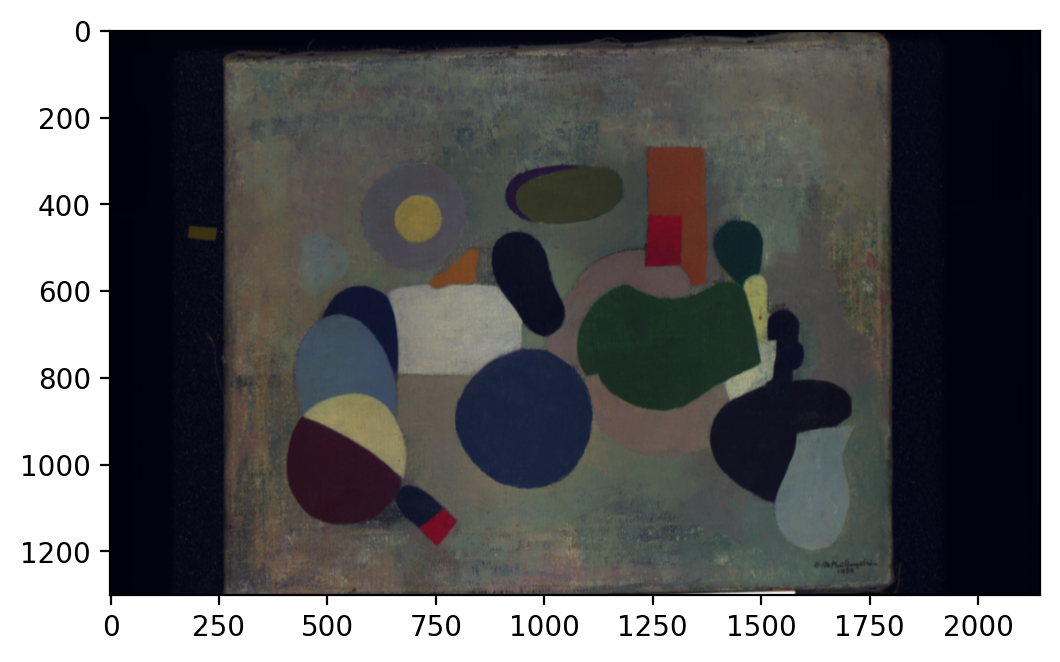

Original Size:  285 135 2144


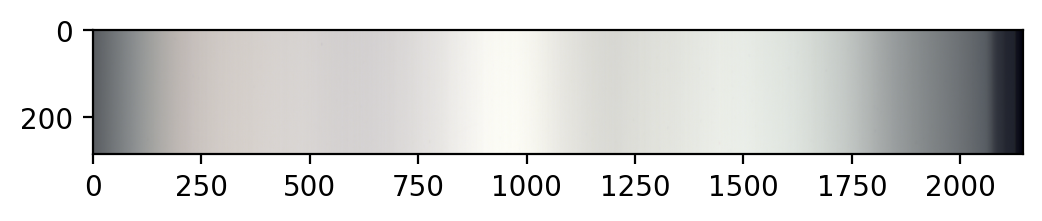

Original Size:  100 135 2144


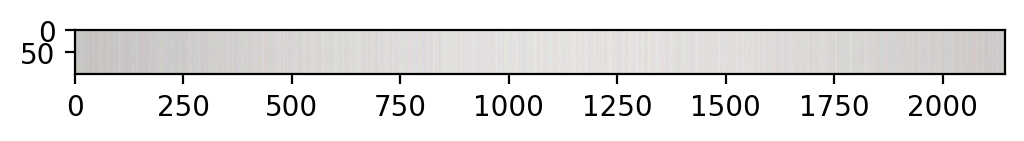

In [9]:
# vis_path = '/content/drive/MyDrive/Summer School/ASI course 2021/Lectures+Exercises/Lecture 5, White correction/Spectral files/ColorChecker_8_binning/capture'
# vis_path = '/content/drive/MyDrive/Summer School/Painting from local mueseum/Paintings from Museum 18.12.2016/Paintings/paintings_Madonna_with_two_0015/capture/'
# vis_path = '/content/drive/MyDrive/Summer School/Painting from local mueseum/Painting from Museum 01.09.2017/Paintings_1.9.2017/VIS_spectral_binning_8/sample_#4/capture' # image 7
# vis_path = '/content/drive/MyDrive/Summer School/Painting from local mueseum/Painting from Museum 01.09.2017/Paintings_1.9.2017/VIS_spectral_binning_8/sample_#5/capture' # image 8
# vis_path = '/content/drive/MyDrive/Summer School/Painting from local mueseum/Painting from Museum 01.09.2017/Paintings_1.9.2017/VIS_spectral_binning_8/sample_#3/capture' # image 9
vis_path = '/content/drive/MyDrive/Summer School/Painting from local mueseum/Painting from Museum 01.09.2017/Paintings_1.9.2017/VIS_spectral_binning_8/sample_#6+#7/capture' # image 11 and 12

# Resizing by line
line_start = 0
line_read = 1300

ch_1 = 61 # Wavelength 631.15
ch_2 = 43 # Wavelength 528.03
ch_3 = 20 # Wavelength 443.56

[spectral_cube, object_RGB, white_cube, w_RGB, dark_cube, d_RGB, waves] = read_n_preview(vis_path, line_start, line_read, ch_1, ch_2, ch_3)

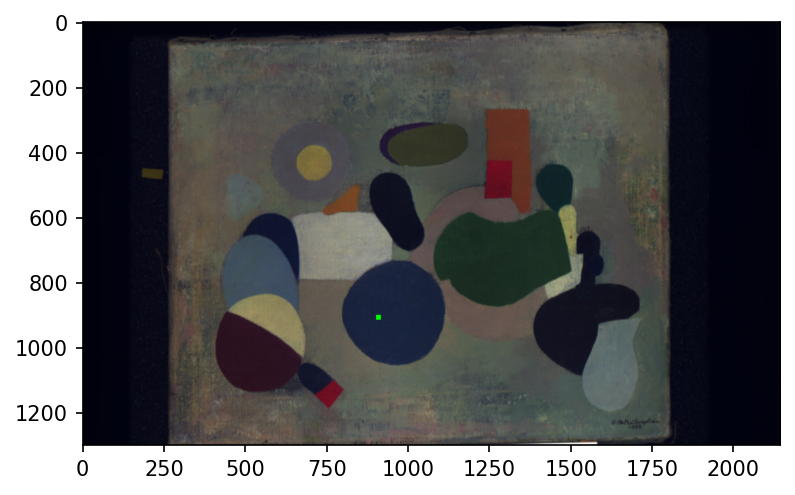

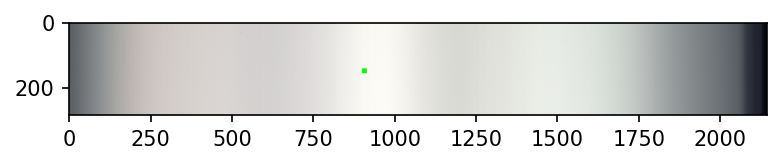

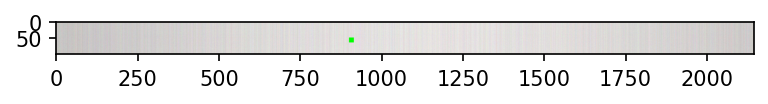

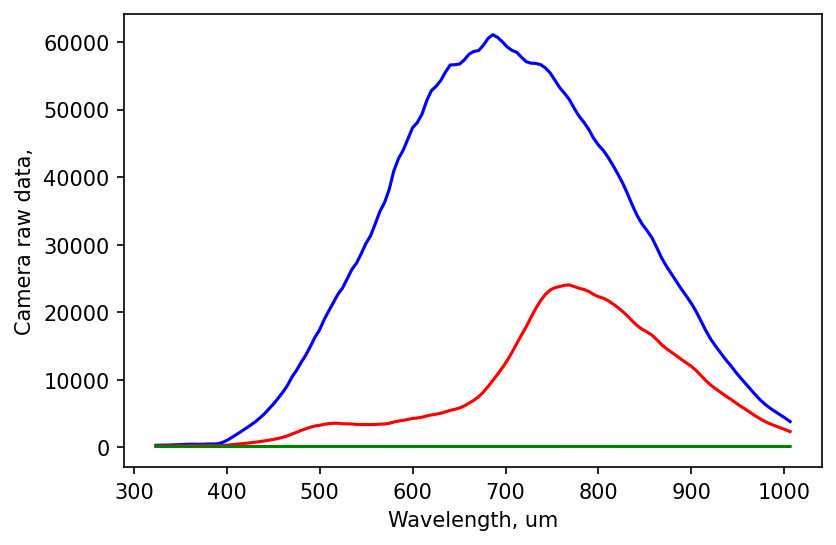

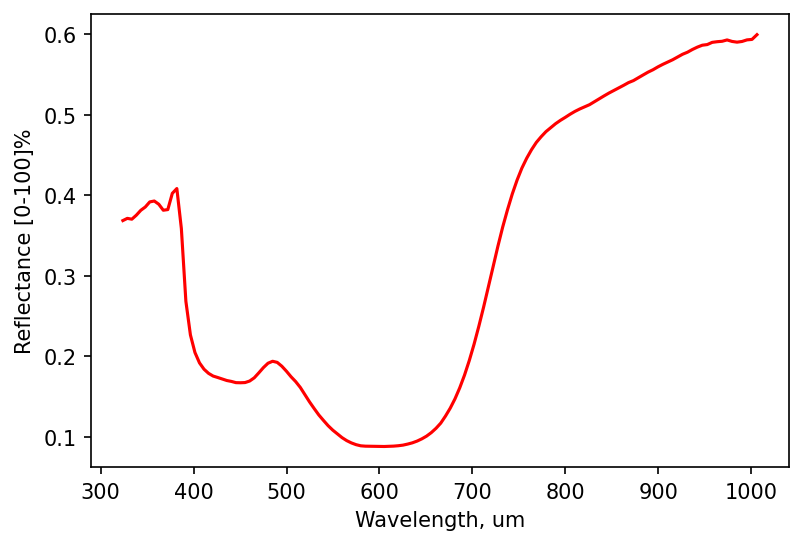

In [10]:
#Get Spectrum for VIS
[vis_spectra, vis_wave] = get_spectra(spectral_cube, object_RGB, white_cube, w_RGB, dark_cube, d_RGB, waves, 900, 900)

## Infrared Spectrum

['DARKREF_IR_emptyname_0008.log', 'DARKREF_IR_emptyname_0008.hdr', 'DARKREF_IR_emptyname_0008.raw', 'WHITEREF_IR_emptyname_0008.raw', 'WHITEREF_IR_emptyname_0008.log', 'WHITEREF_IR_emptyname_0008.hdr', 'IR_emptyname_0008.log', 'IR_emptyname_0008.raw', 'IR_emptyname_0008.hdr']
Original Size:  491 256 320
Resized to:  (190, 256, 320)
[ 918.91  925.31  931.72  938.13  944.53  950.93  957.33  963.73  970.12
  976.52  982.91  989.3   995.69 1002.08 1008.47 1014.85 1021.24 1027.62
 1034.   1040.38 1046.76 1053.14 1059.51 1065.89 1072.26 1078.63 1085.
 1091.37 1097.74 1104.11 1110.47 1116.83 1123.2  1129.56 1135.92 1142.28
 1148.63 1154.99 1161.34 1167.7  1174.05 1180.4  1186.75 1193.1  1199.45
 1205.8  1212.14 1218.49 1224.83 1231.17 1237.51 1243.85 1250.19 1256.53
 1262.87 1269.21 1275.54 1281.87 1288.21 1294.54 1300.87 1307.2  1313.53
 1319.86 1326.19 1332.52 1338.84 1345.17 1351.49 1357.81 1364.14 1370.46
 1376.78 1383.1  1389.42 1395.74 1402.06 1408.37 1414.69 1421.01 1427.32
 1433.64 14

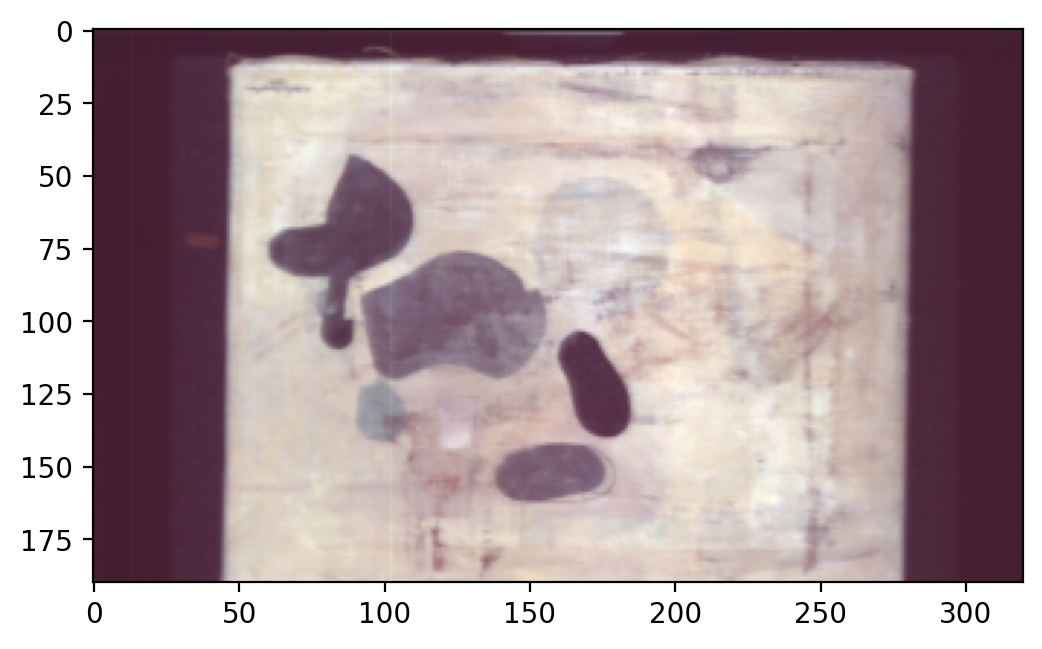

Original Size:  91 256 320


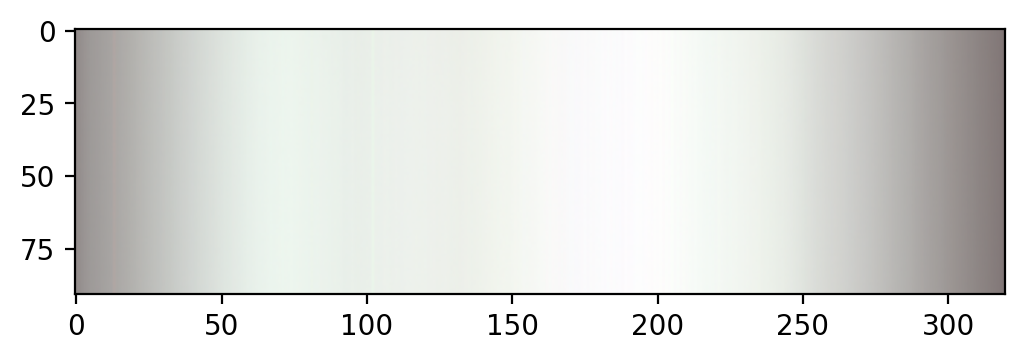

Original Size:  100 256 320


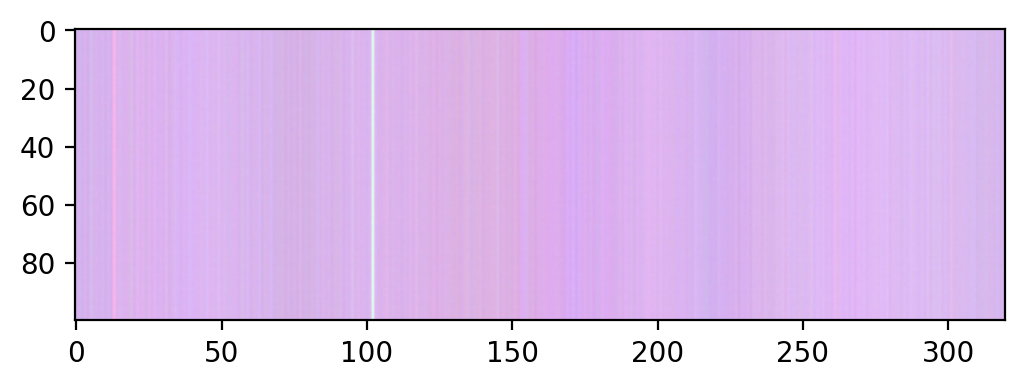

In [11]:
# ir_path = '/content/drive/MyDrive/Summer School/Painting from local mueseum/Paintings from Museum 18.12.2016/Paintings/IR_IR1_0019/capture/'
# ir_path = '/content/drive/MyDrive/Summer School/Painting from local mueseum/Painting from Museum 01.09.2017/Paintings_1.9.2017/IR/sample_#4/capture' # image 7
# ir_path = '/content/drive/MyDrive/Summer School/Painting from local mueseum/Painting from Museum 01.09.2017/Paintings_1.9.2017/IR/sample_#5/capture' # image 8
# ir_path = '/content/drive/MyDrive/Summer School/Painting from local mueseum/Painting from Museum 01.09.2017/Paintings_1.9.2017/IR/sample_#3/capture' # image 9
ir_path = '/content/drive/MyDrive/Summer School/Painting from local mueseum/Painting from Museum 01.09.2017/Paintings_1.9.2017/IR/sample_#6+#7/capture' # image 11 and 12

# Resizing by line
line_start = 0
line_read = 190

ch_1 = 41 # Wavelength 631.15
ch_2 = 116 # Wavelength 528.03`
ch_3 = 183 # Wavelength 443.56

[spectral_cube, object_RGB, white_cube, w_RGB, dark_cube, d_RGB, waves] = read_n_preview(ir_path, line_start, line_read, ch_1, ch_2, ch_3)


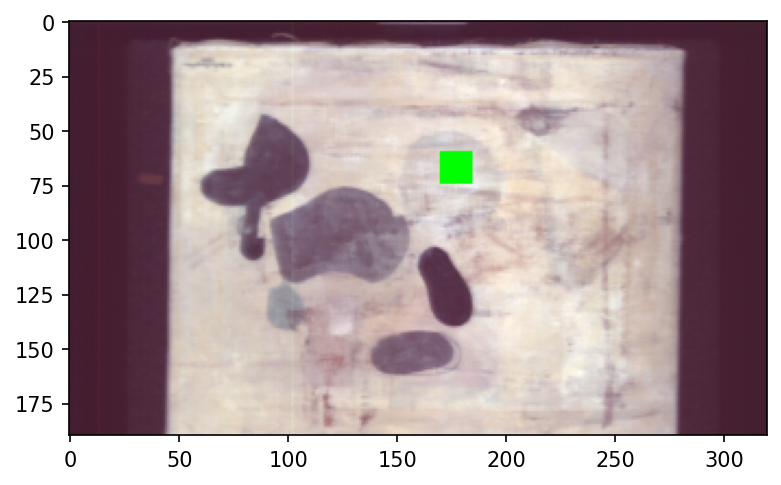

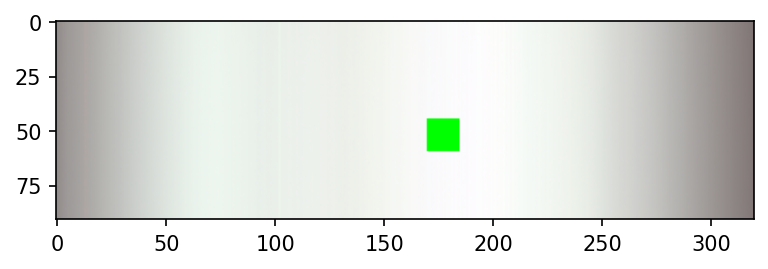

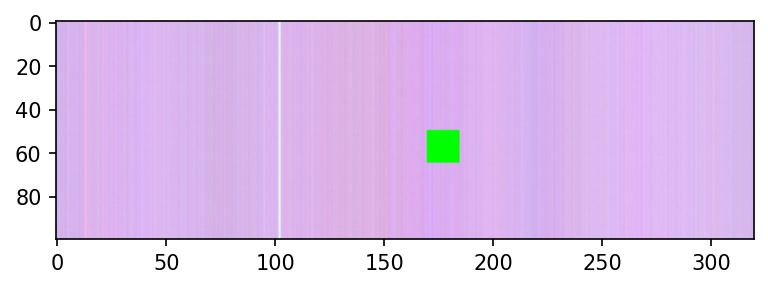

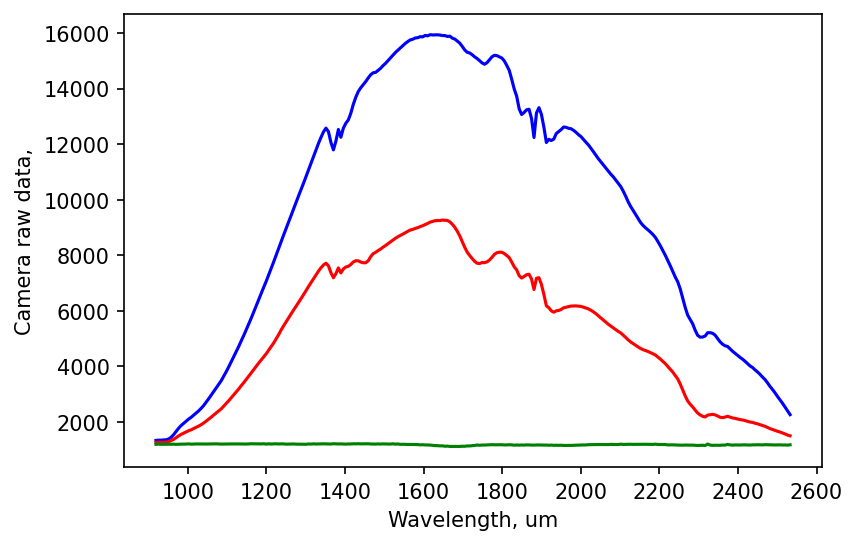

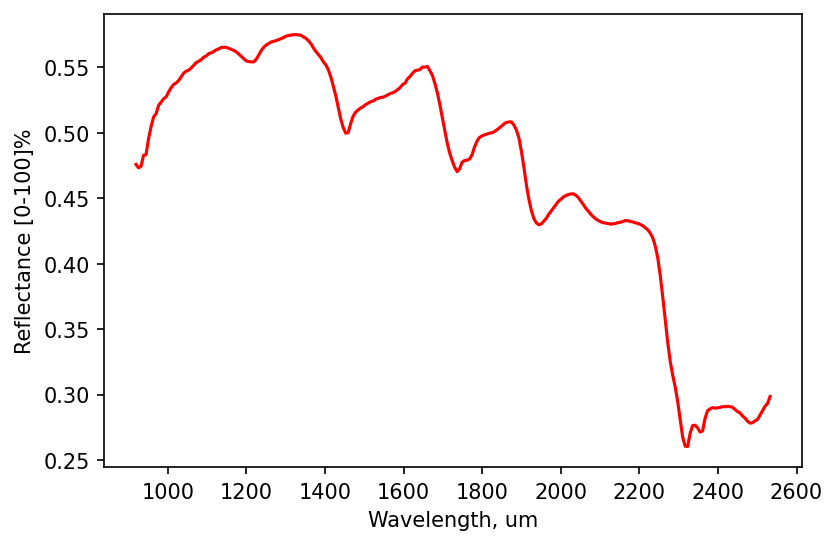

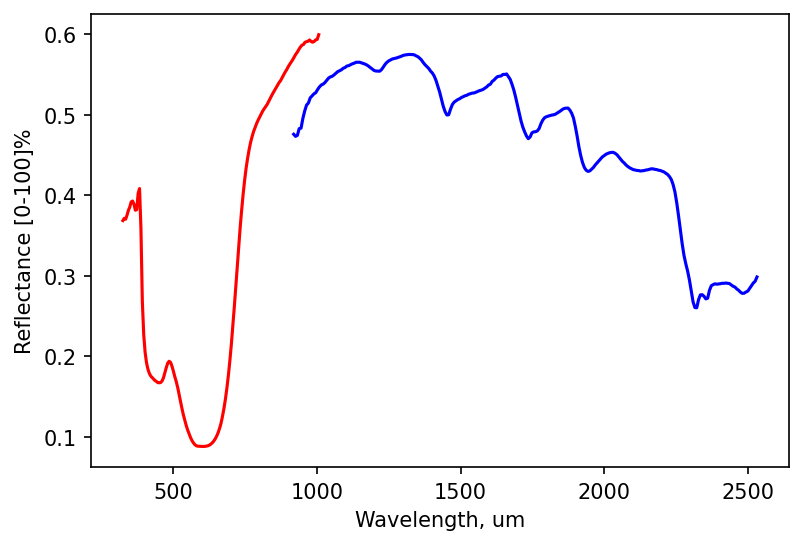

"\nwith open('/content/drive/MyDrive/Summer School/savedata/image_11.npy', 'wb') as f:\n    numpy.save(f, vis_spectra)\n    numpy.save(f, ir_spectra)\n"

In [12]:
#Get Spectrum for IR
[ir_spectra, ir_wave] = get_spectra(spectral_cube, object_RGB, white_cube, w_RGB, dark_cube, d_RGB, waves, 170, 60)

plt.plot(vis_wave, vis_spectra, "r")
plt.plot(ir_wave, ir_spectra, "b")
plt.xlabel('Wavelength, um')
plt.ylabel('Reflectance [0-100]%')
plt.show()

'''
with open('/content/drive/MyDrive/Summer School/savedata/image_11.npy', 'wb') as f:
    numpy.save(f, vis_spectra)
    numpy.save(f, ir_spectra)
'''

In [13]:
def get_spectral_data(file_path):
  with open(file_path, 'rb') as f:
    a = numpy.load(f)
    b = numpy.load(f)
  return (a, b)

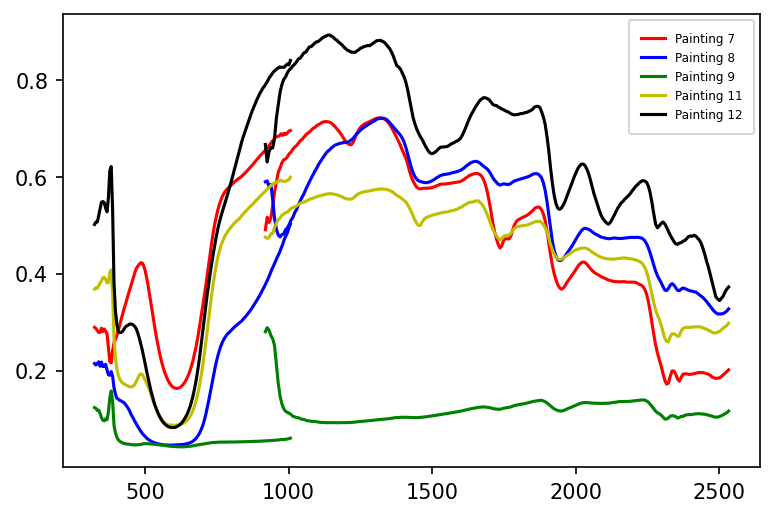

In [18]:
[vis_7, ir_7] = get_spectral_data('/content/drive/MyDrive/Summer School/savedata/image_7.npy')
[vis_8, ir_8] = get_spectral_data('/content/drive/MyDrive/Summer School/savedata/image_8.npy')
[vis_9, ir_9] = get_spectral_data('/content/drive/MyDrive/Summer School/savedata/image_9.npy')
[vis_11, ir_11] = get_spectral_data('/content/drive/MyDrive/Summer School/savedata/image_11.npy')
[vis_12, ir_12] = get_spectral_data('/content/drive/MyDrive/Summer School/savedata/image_12.npy')
plt.plot(vis_wave, vis_7, "r")
plt.plot(ir_wave, ir_7, "r", label='Painting 7')
plt.plot(vis_wave, vis_8, "b")
plt.plot(ir_wave, ir_8, "b", label='Painting 8')
plt.plot(vis_wave, vis_9, "g")
plt.plot(ir_wave, ir_9, "g", label='Painting 9')
plt.plot(vis_wave, vis_11, "y")
plt.plot(ir_wave, ir_11, "y", label='Painting 11')
plt.plot(vis_wave, vis_12, "black")
plt.plot(ir_wave, ir_12, "black", label='Painting 12')
plt.legend(borderpad=1, fontsize='xx-small', markerscale=0.5)

# Using advanced method for white correction

In [ ]:
# White Correction - Advance method
def white_correction(spectral_cube, white_cube, dark_cube):
  white_av = numpy.sum(white_cube, axis = 0)
  #print(white_cube.shape)
  #print(white_av.shape)
  dark_av = numpy.sum(dark_cube, axis = 0)

  [lines, bands, samples] = spectral_cube.shape
  #print(spectral_cube.shape)
  upper_part = numpy.zeros((lines, bands, samples), dtype=numpy.float32)
  corrected_spectral_cube = numpy.zeros((lines, bands, samples), dtype=numpy.float32)
  # Subtract [image - dark]
  for i in range(lines):
    upper_part[i,:,:] = numpy.subtract(spectral_cube[i,:,:], dark_av) 
  # Subtract [white - dark]
  lower_part = numpy.subtract(white_av, dark_av) 
  # Subtract [image - dark]
  for i in range(lines):
    corrected_spectral_cube[i,:,:] = numpy.divide(upper_part[i,:,:], lower_part)

  return corrected_spectral_cube

In [ ]:
corr_spectral_cube = white_correction(spectral_cube, white_cube, dark_cube)
object_RGB = preview_RGB(corr_spectral_cube, ch_1, ch_2, ch_3)                         
region = find_region_spectrum(corr_spectral_cube, object_RGB, 1030, 1070, 640, 680) 